In [7]:
''' Import modules. '''

import sys
import pywt
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from copy import deepcopy

sys.path.insert(0, '/home/elott1/code')

from ColorDataUtils.DDPIutils import DDPIutils
from NDNT.utils import DanUtils as DU

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
''' Load data into seperate trials. '''

datadir = '/home/dbutts/ColorV1/Data/'
f = 'Jocamo0331_dpi_calibrated'
data = DDPIutils(filename=f, data_dir=datadir)

Seperating trials...
Done.


In [3]:
''' Process all trials. Takes about 1 min. per 200 trials. '''

for i in tqdm.tqdm(range(data.num_trials)):
    data.process_trial(tr=i, verbose=False)
    data.process_fixations(tr=i)

  0%|          | 0/1409 [00:00<?, ?it/s]

100%|██████████| 1409/1409 [07:00<00:00,  3.35it/s]


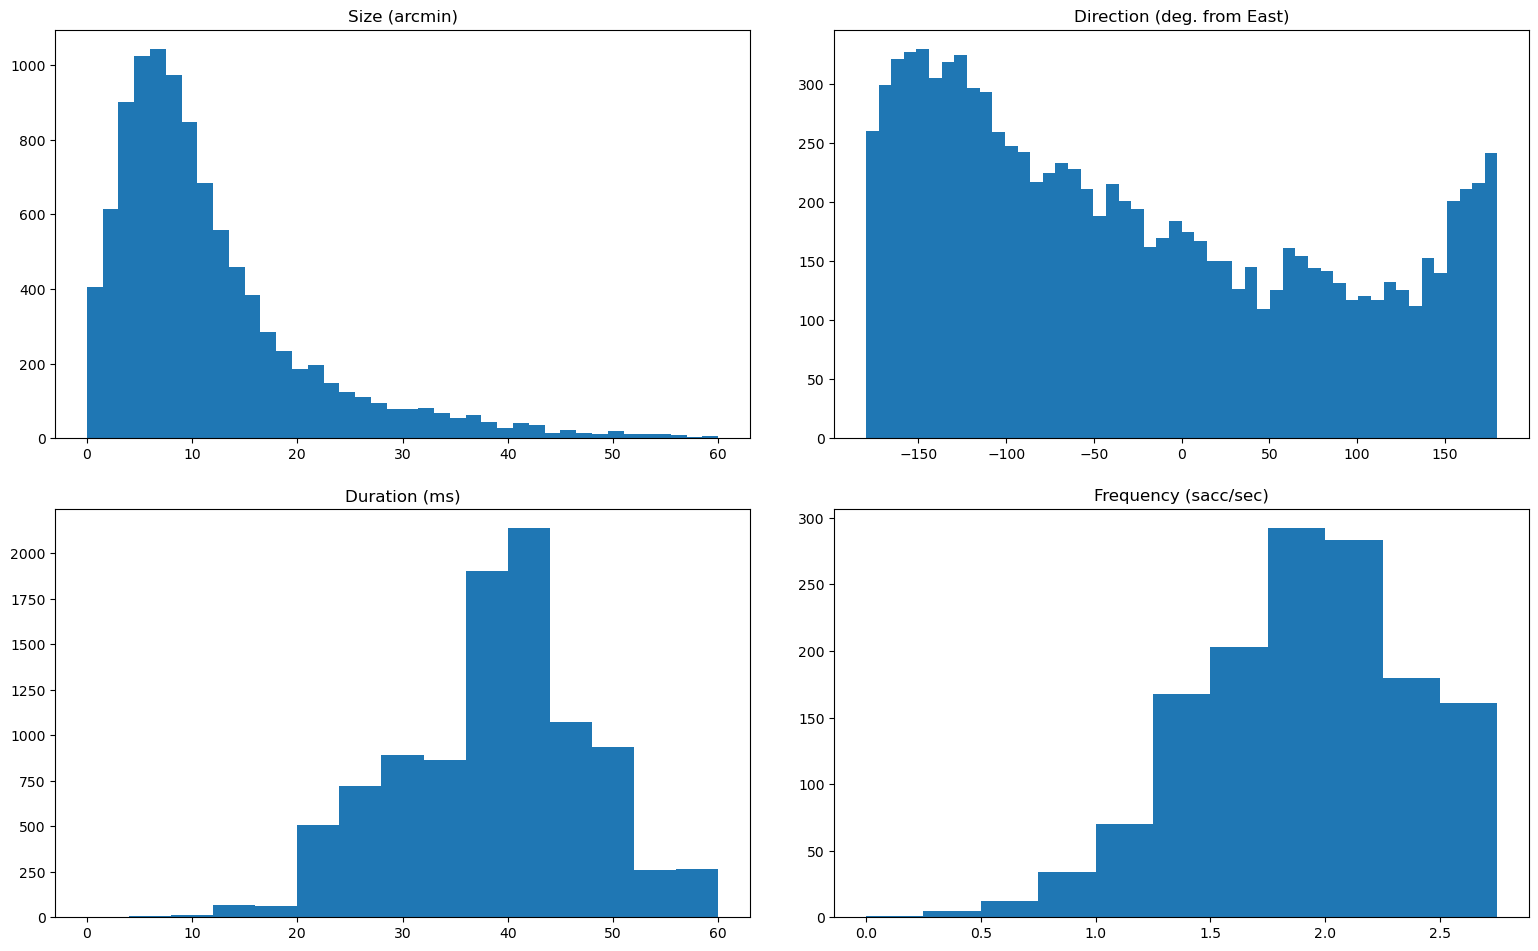

In [4]:
''' View saccade stats. '''

data.saccade_stats()

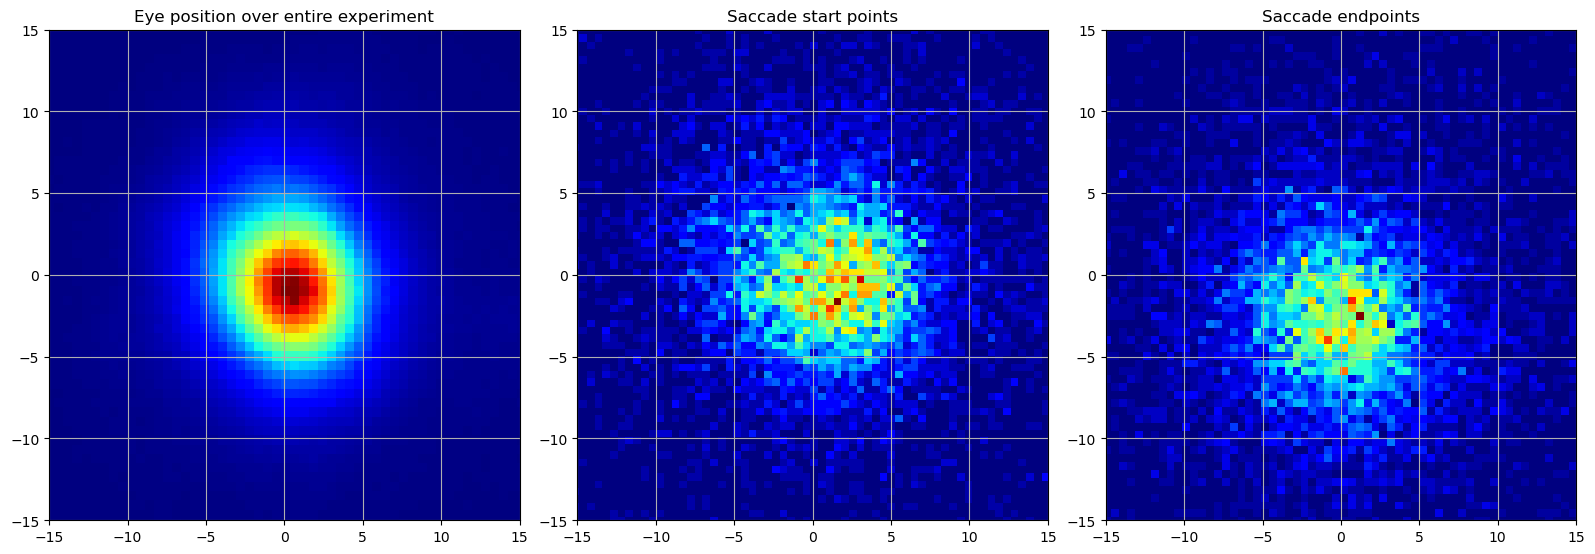

In [5]:
''' Eye position density at saccade points. '''

full_et = np.zeros([0,3])
for et in data.trial_et:
    full_et = np.concatenate([full_et, et])
full_et = np.delete(full_et, np.unique(np.where(full_et==0)), axis=0)

full_start = np.zeros([0,2])
full_end = np.zeros([0,2])
for t, dts in enumerate(data.sacc_dt):
    for dt in dts:
        full_start = np.concatenate([full_start, data.trial_et[t][int(dt[0]),1:].reshape(1,2)])
        full_end = np.concatenate([full_end, data.trial_et[t][int(dt[1])-1,1:].reshape(1,2)])

DU.ss(1,3,rh=5.5)
plt.subplot(131)
plt.hist2d(full_et[:,1], full_et[:,2], bins=(300, 300), cmap=plt.cm.jet)
plt.xlim(-15,15)
plt.grid()
plt.ylim(-15,15)
plt.title('Eye position over entire experiment')
plt.subplot(132)
plt.hist2d(full_start[:,0], full_start[:,1], bins=(300, 300), cmap=plt.cm.jet)
plt.xlim(-15,15)
plt.grid()
plt.ylim(-15,15)
plt.title('Saccade start points')
plt.subplot(133)
plt.hist2d(full_end[:,0], full_end[:,1], bins=(300, 300), cmap=plt.cm.jet)
plt.xlim(-15,15)
plt.grid()
plt.ylim(-15,15)
plt.title('Saccade endpoints')
plt.show()

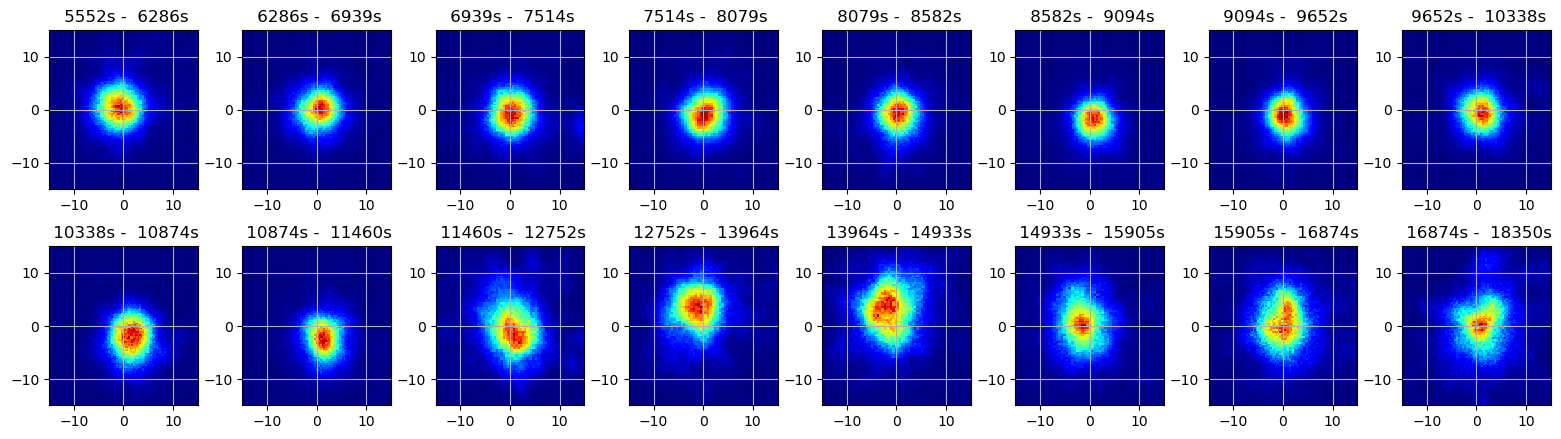

In [6]:
''' Eye positon density over time. '''

num_chunk = 16
chunk = full_et.shape[0]//num_chunk
c = 8
r = math.ceil(num_chunk/c)

DU.ss(r,c,rh=2.3)
plt.tight_layout(pad=2)
plt.subplots_adjust(wspace=0.3)
for i in range(num_chunk):
    plt.subplot(r,c,i+1)
    plt.title(f'{full_et[chunk*i,0]: .0f}s - {full_et[chunk*(i+1),0]: .0f}s')
    plt.hist2d(full_et[chunk*i:chunk*(i+1),1], full_et[chunk*i:chunk*(i+1),2], bins=(300, 300), cmap=plt.cm.jet)
    plt.xlim(-15,15)
    plt.ylim(-15,15)
    plt.grid()
plt.show()

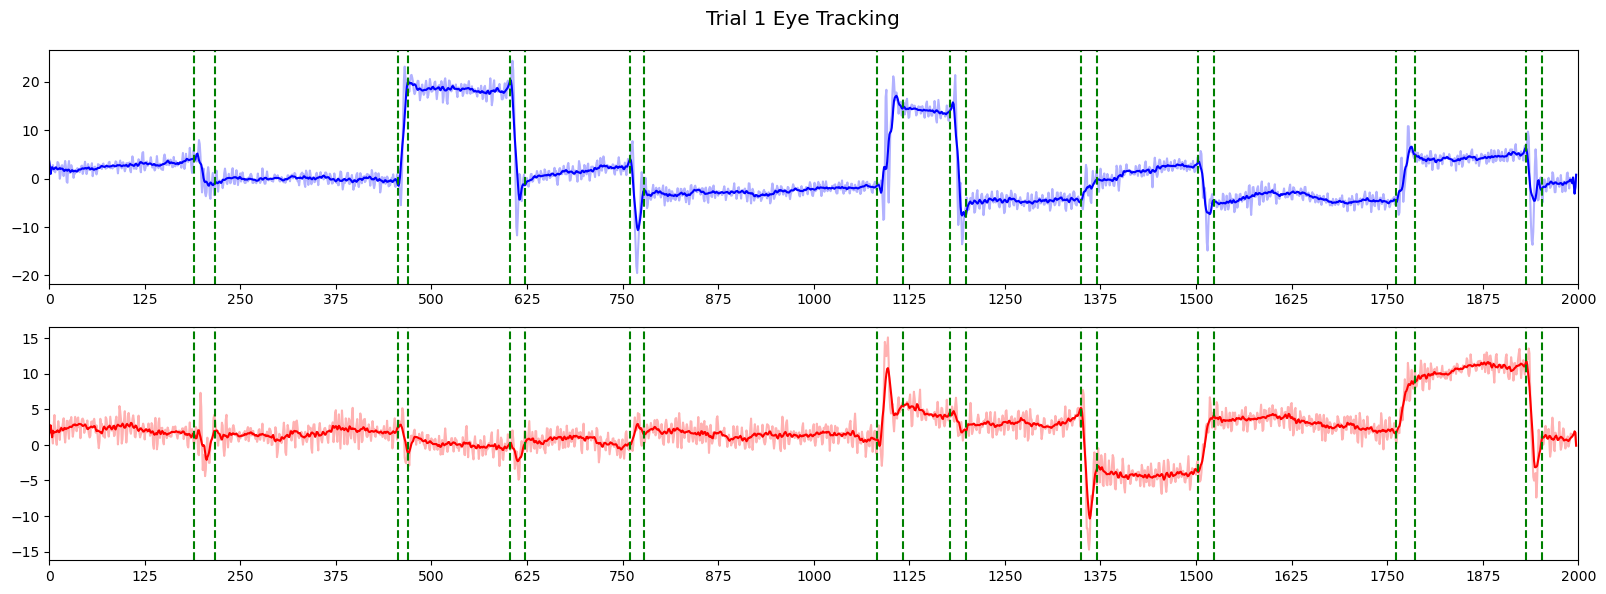

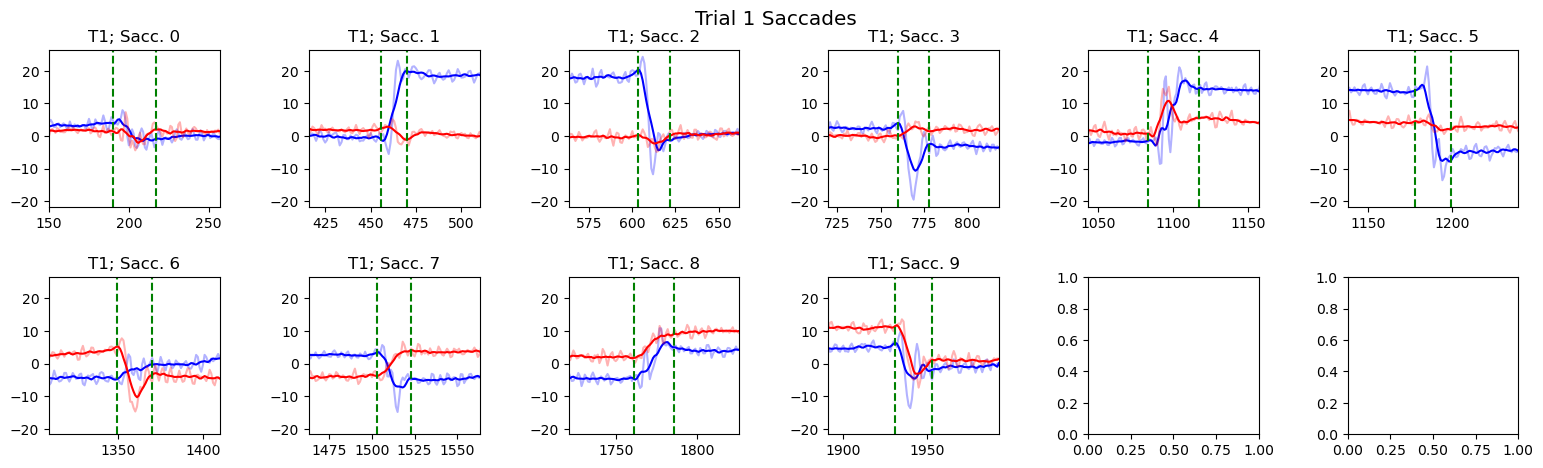

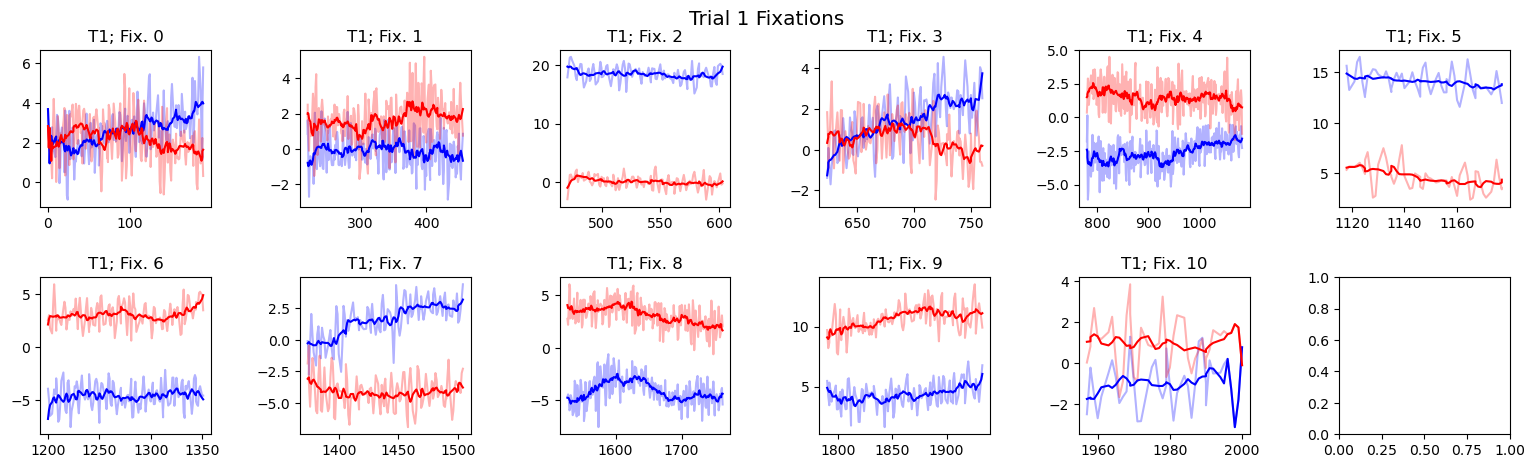

In [9]:
''' Process and plot a single trial. '''

tr = 1

if (data.processed[tr,0] == 0):
    data.process_trial(tr)
if (data.processed[tr,1] == 0):
    data.process_fixations(tr)
    
data.plot_trial(tr)
data.plot_saccades(tr, c=6, rh=2.5)
data.plot_fixations(tr, c=6, rh=2.5)

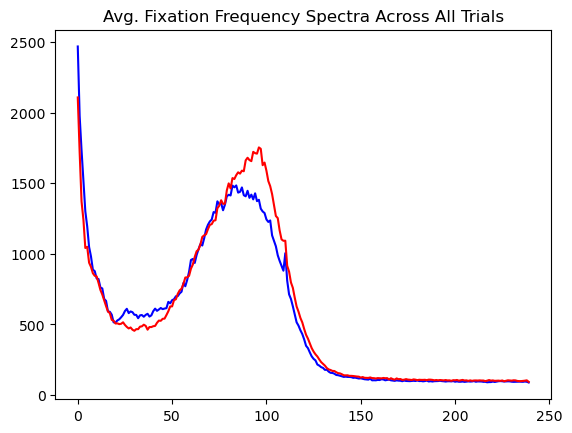

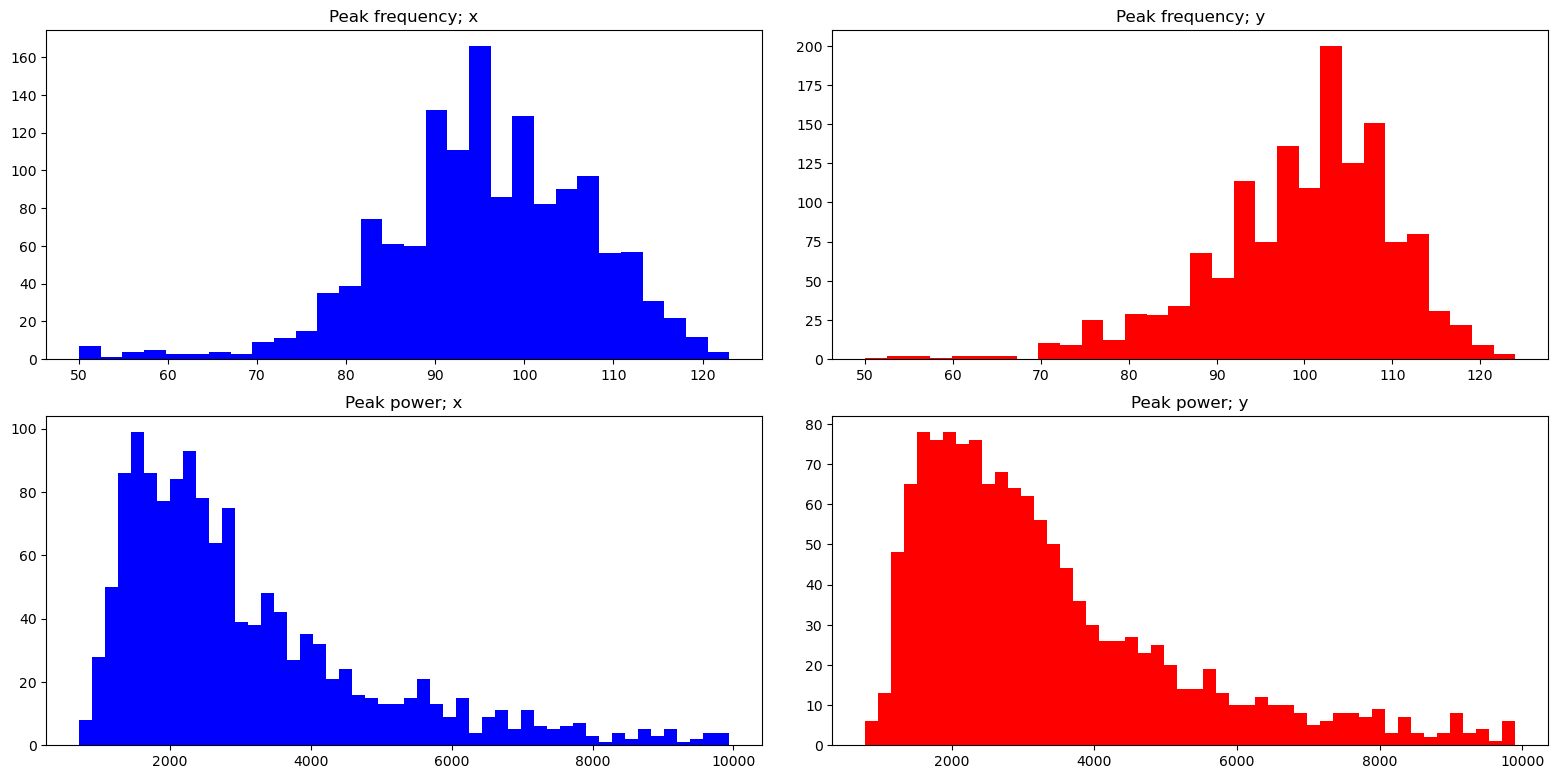

In [4]:
''' Calculate and plot average frequency spectra for entire experiment. '''

data.fft_fixations(to_plot=2)

In [5]:
''' Apply low-pass filter (hard cutoff) to each fixation of every trial. '''

st_avg, end_avg = data.LPfilt_trials()

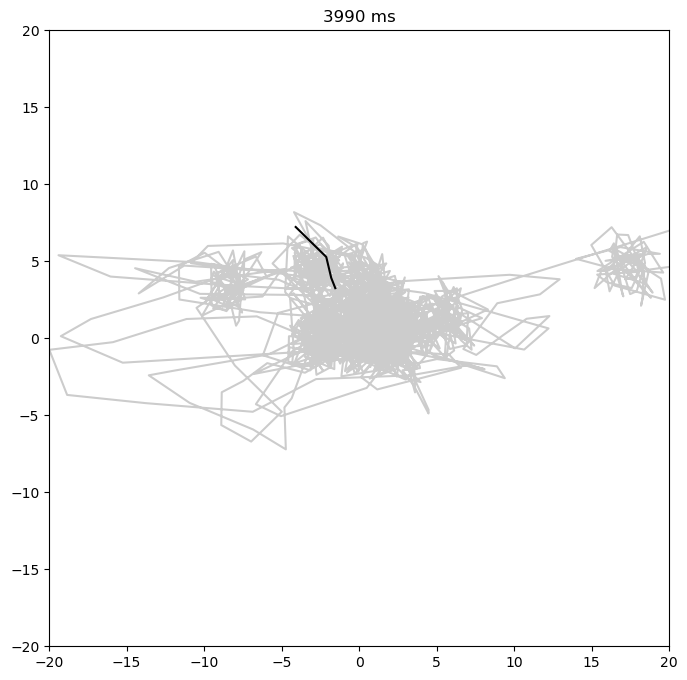

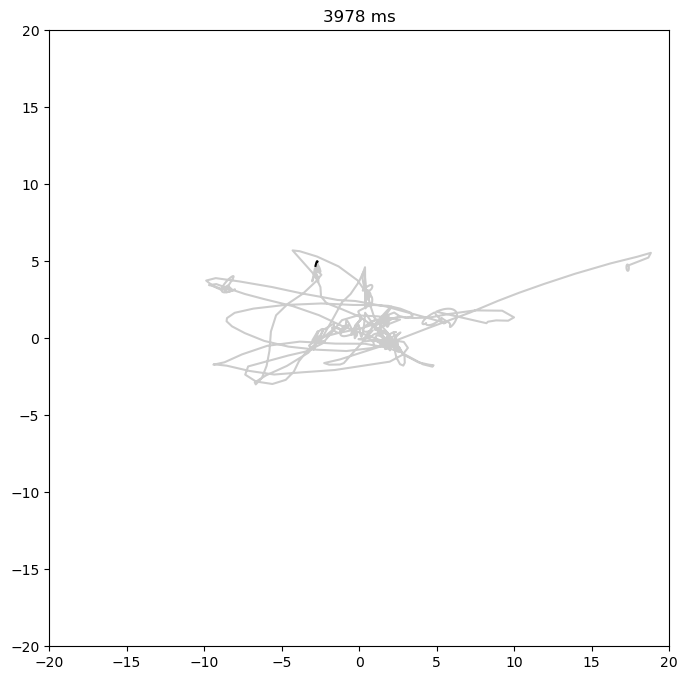

In [12]:
''' Plot and save GIFs of a trial. Takes about 4 min. per gif for a full trial. '''
data.generate_gif(tr=17)
data.generate_gif(tr=17, filtered=True, trail=10)

In [13]:
''' Perform wavelet decompositions of all trials. '''

full_wavelet = data.wavelet_transform()

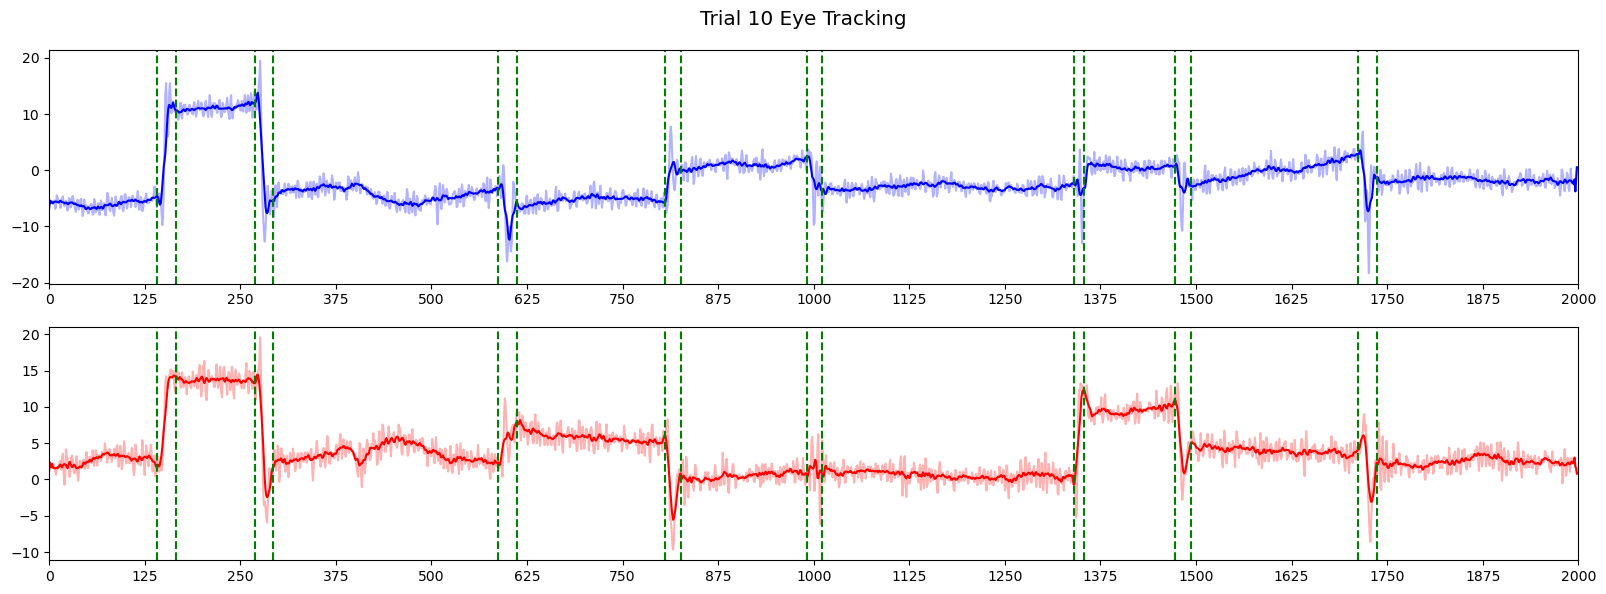

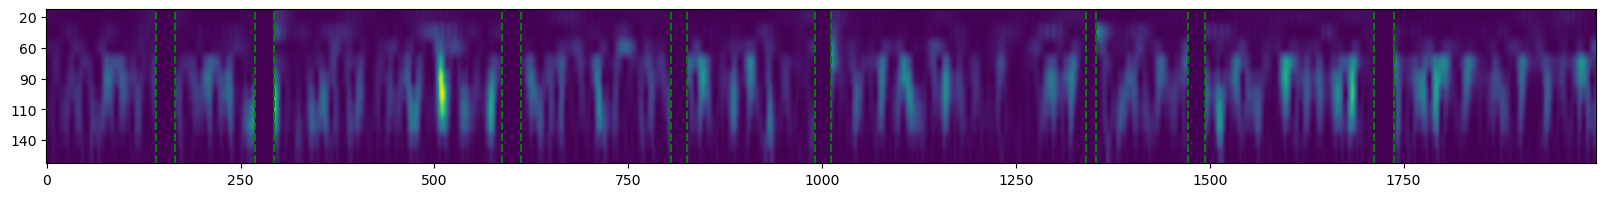

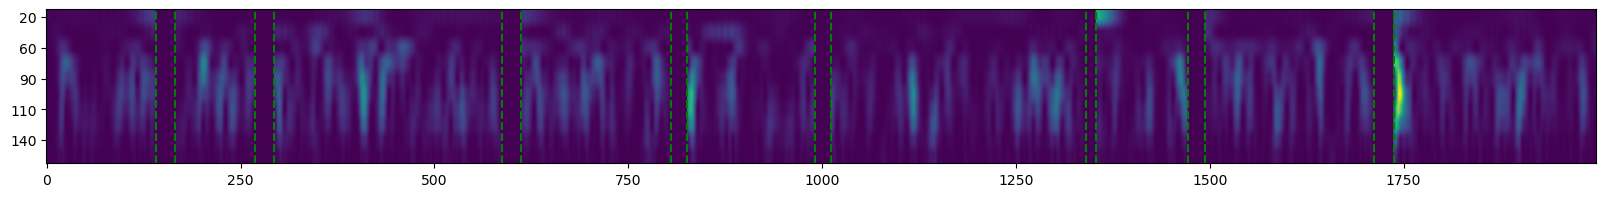

In [15]:
# Plot decomposition of a single trial

tr = 10
freqs = np.array([20, 40, 60, 80, 90, 100, 110, 120, 140, 160])
data.plot_trial(tr)

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(full_wavelet[tr][:,:,0].T, aspect='auto')
plt.yticks([2*i for i in range(5)],[freqs[i] for i in range(10) if i%2 == 0])
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(full_wavelet[tr][:,:,1].T, aspect='auto')
plt.yticks([2*i for i in range(5)],[freqs[i] for i in range(10) if i%2 == 0])
for sacc in data.sacc_dt[tr]:
    plt.axvline(x=sacc[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=sacc[1], color='green', linestyle='dashed', alpha=1)
plt.show()

In [16]:
''' Calculate ocular drift stats. '''
data.calc_drift()

all_arcs = np.zeros(0)
all_disp = np.zeros(0)
all_dx = np.zeros(0)
all_dy = np.zeros(0)
for trial in range(data.num_trials):
    all_arcs = np.concatenate([all_arcs, data.fix_drift[trial][:,0]])
    all_dx = np.concatenate([all_dx, data.fix_drift[trial][:,1]])
    all_dy = np.concatenate([all_dy, data.fix_drift[trial][:,2]])
    all_disp = np.concatenate([all_disp, data.fix_drift[trial][:,3]])

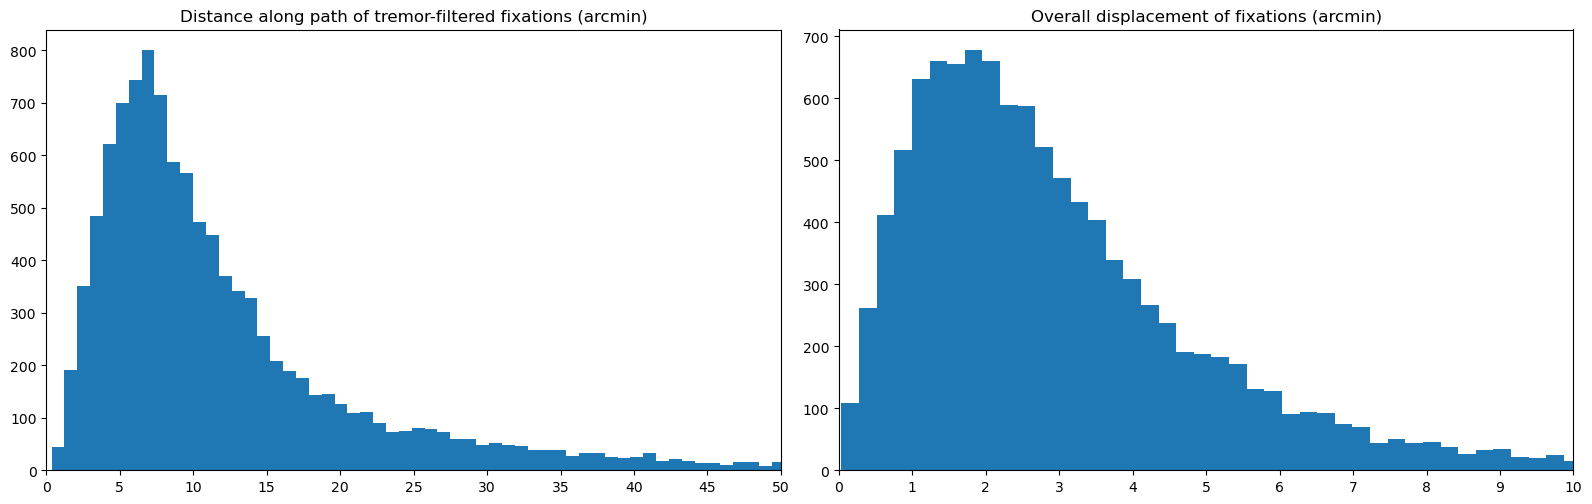

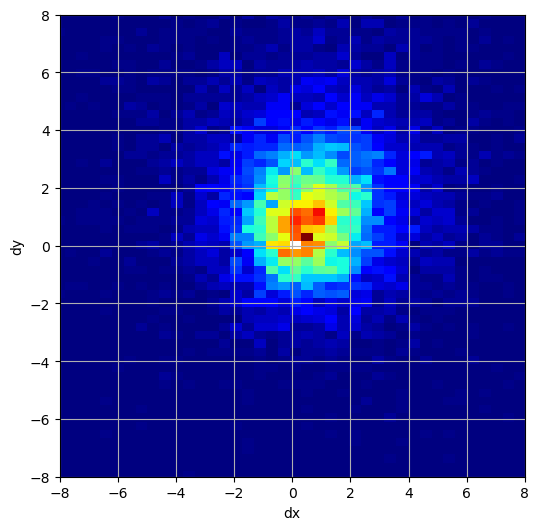

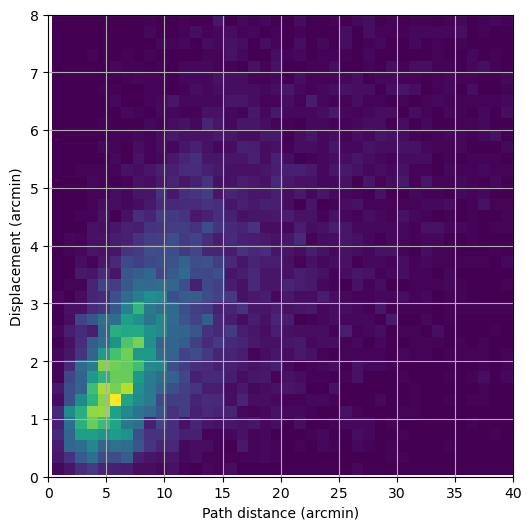

In [17]:
''' Plot ocular drift stats. '''

DU.ss(1,2,rh=5)
ind = np.where(all_arcs == 0)

all_arcs = np.delete(all_arcs, ind)
plt.subplot(121)
plt.hist(all_arcs, bins=500)
plt.xticks(range(0,51,5))
plt.xlim(0,50)
plt.title('Distance along path of tremor-filtered fixations (arcmin)')

all_disp = np.delete(all_disp, ind)
plt.subplot(122)
plt.hist(all_disp, bins=400)
plt.xticks(range(11))
plt.xlim(0,10)
plt.title('Overall displacement of fixations (arcmin)')
plt.show()

plt.figure(figsize=(6,6))
plt.hist2d(all_dx, all_dy, bins=(400,400), cmax=150, cmap=plt.cm.jet)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.grid()
plt.xlabel('dx')
plt.ylabel('dy')
plt.show()

inds = np.unique(np.concatenate([np.where(all_arcs > 40)[0], np.where(all_disp > 8)[0]]))
all_arcs0 = np.delete(all_arcs, inds)
all_disp0 = np.delete(all_disp, inds)

plt.figure(figsize=(6,6))
plt.hist2d(all_arcs0, all_disp0, bins=(40,40), cmap='viridis')
plt.xlim(0,40)
plt.ylim(0,8)
plt.grid()
plt.xlabel('Path distance (arcmin)')
plt.ylabel('Displacement (arcmin)')
plt.show()

In [18]:
''' Calculate displacement stats. '''

sacc_x = np.zeros(0)
sacc_y = np.zeros(0)

for tr in range(data.num_trials):
    x = data.sacc_xy[tr][:,0].reshape(-1)
    y = data.sacc_xy[tr][:,1].reshape(-1)
    sacc_x = np.concatenate([sacc_x, x])
    sacc_y = np.concatenate([sacc_y, y])

idx = np.unique(np.concatenate((np.where(np.abs(sacc_x) > 20)[0], np.where(np.abs(sacc_y) > 20)[0])))
sacc_x = np.delete(sacc_x, idx)
sacc_y = np.delete(sacc_y, idx)

idx_drift = np.unique(np.concatenate((np.where(np.abs(all_dx) > 20)[0], np.where(np.abs(all_dy) > 20)[0])))
all_dx = np.delete(all_dx, idx_drift)
all_dy = np.delete(all_dy, idx_drift)

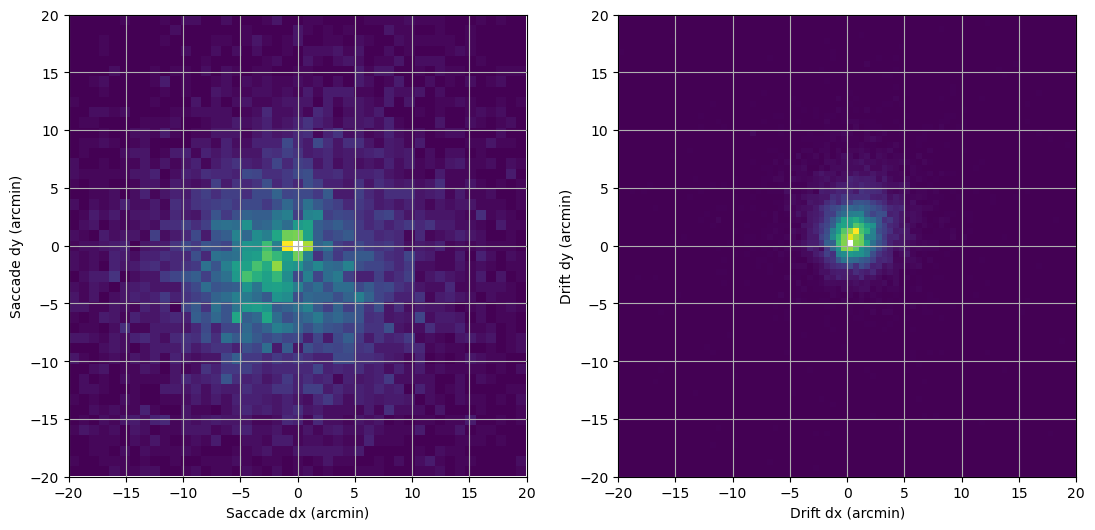

Mean saccade: (-0.86, -1.89)
Mean drift: ( 0.66,  1.43)


In [19]:
''' Plot displacement stats. '''

plt.subplots(1,2,figsize=(13,6))

plt.subplot(121)
plt.hist2d(sacc_x, sacc_y, cmax=70, bins=(45,45), cmap='viridis')
plt.grid()
plt.xlabel('Saccade dx (arcmin)')
plt.ylabel('Saccade dy (arcmin)')
plt.xlim(-20,20)
plt.ylim(-20,20)

plt.subplot(122)
plt.hist2d(all_dx, all_dy, cmax=250, bins=(np.arange(-20,21,0.5),np.arange(-20,21,0.5)), cmap='viridis')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.grid()
plt.xlabel('Drift dx (arcmin)')
plt.ylabel('Drift dy (arcmin)')
plt.show()

print(f'Mean saccade: ({sacc_x.mean(): 0.2f}, {sacc_y.mean(): 0.2f})')
print(f'Mean drift: ({all_dx.mean(): 0.2f}, {all_dy.mean(): 0.2f})')

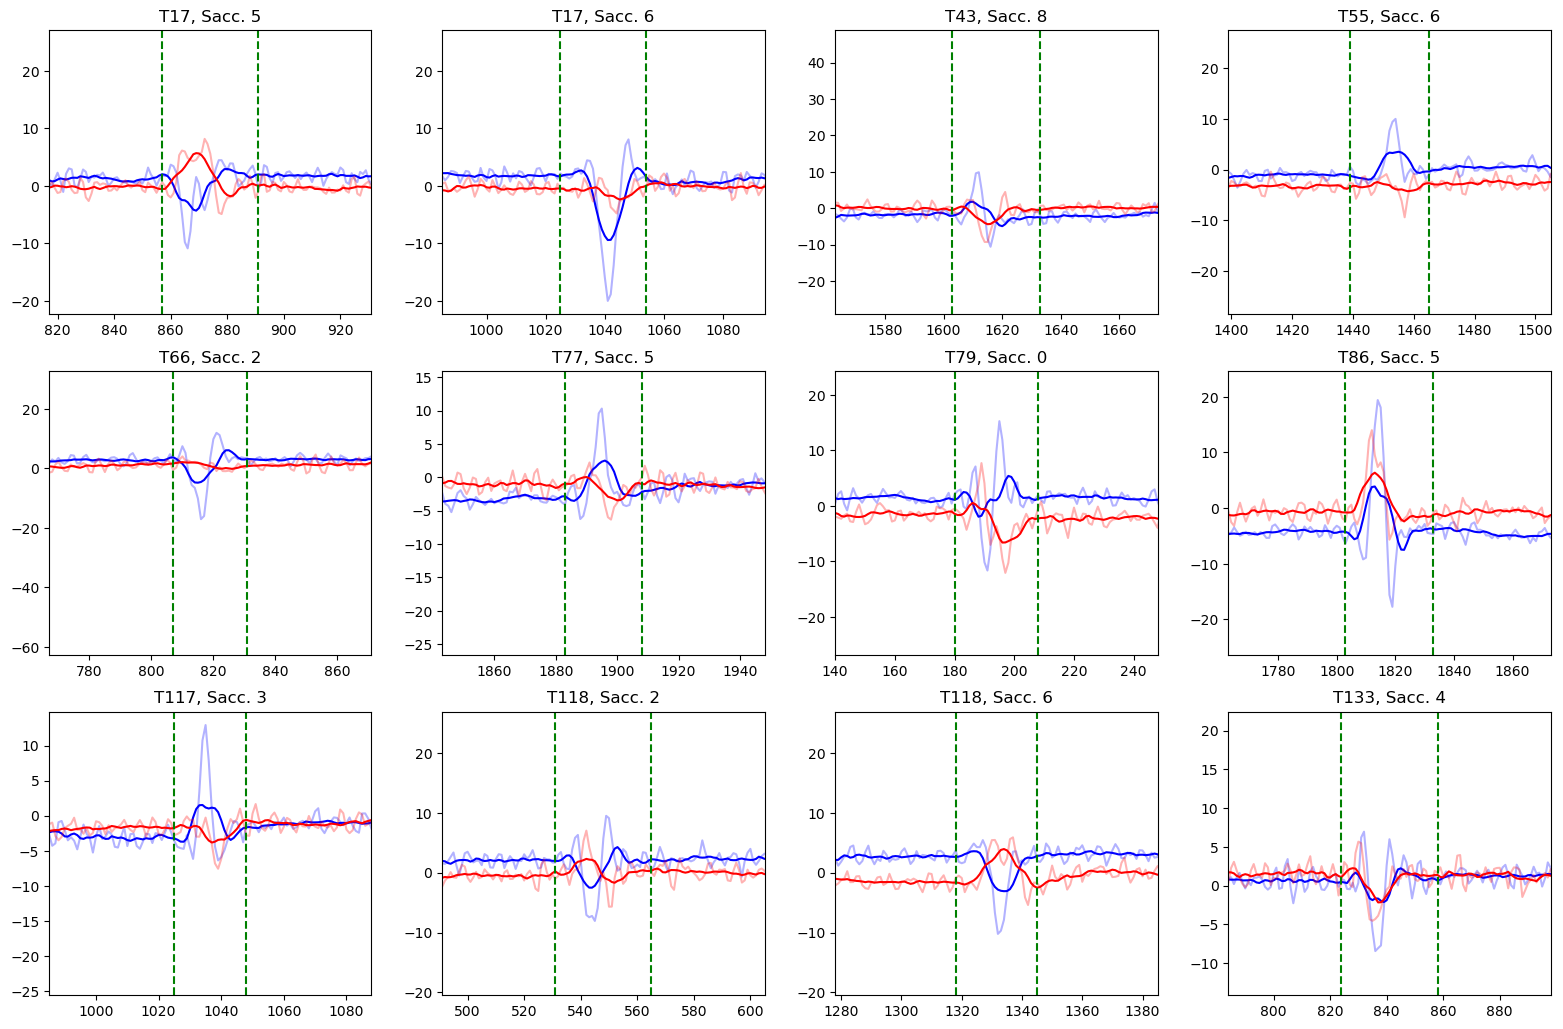

In [20]:
''' Look at the smallest saccades detected. '''

mini_saccs = np.zeros([0,2], dtype=np.int32)
for tr, saccs in enumerate(data.sacc_sizes):
    for s, sacc in enumerate(saccs):
        if sacc < 1:
            mini_saccs = np.concatenate([mini_saccs, np.array([[tr, s]])])

DU.ss(3,4,rh=3.5)
plt.tight_layout(pad=2)
for i in range(12):
    tr = mini_saccs[i,0]
    s = data.sacc_dt[tr][mini_saccs[i,1]]
    plt.subplot(3,4,i+1)
    plt.title(f'T{tr}, Sacc. {mini_saccs[i,1]}')
    plt.plot(data.trial_et[tr][:, 1], alpha=0.3, color='blue')
    plt.plot(data.trial_avg_et[tr][:, 1], color='blue')
    plt.plot(data.trial_et[tr][:, 2], alpha=0.3, color='red')
    plt.plot(data.trial_avg_et[tr][:, 2], color='red')
    plt.xlim(max(0,int(s[0])-40),min(data.trial_et[tr].shape[0], int(s[1])+40))
    plt.axvline(x=s[0], color='green', linestyle='dashed', alpha=1)
    plt.axvline(x=s[1], color='green', linestyle='dashed', alpha=1)

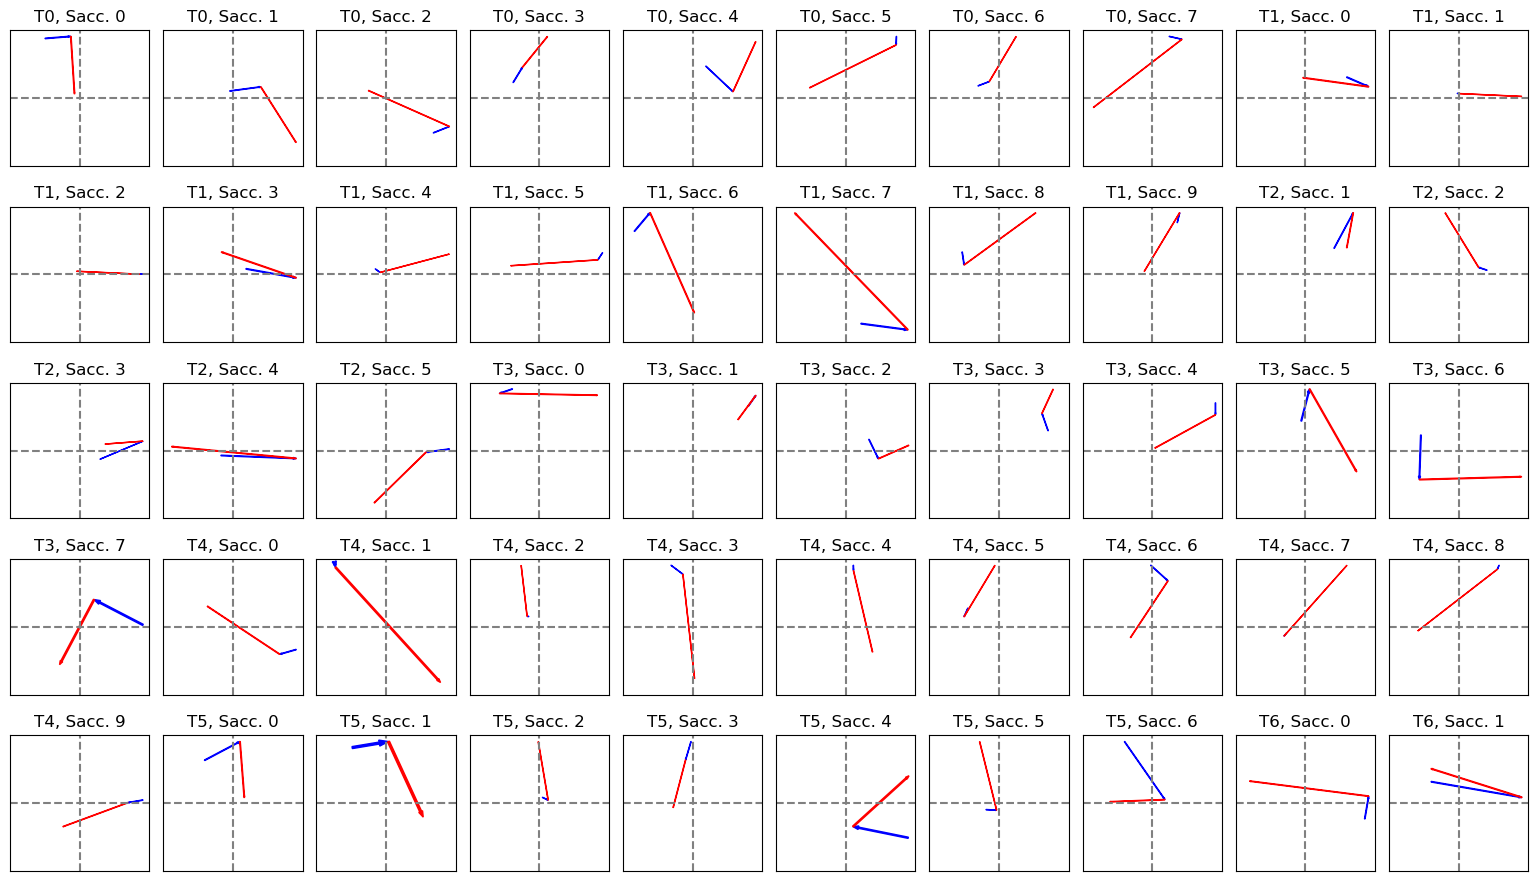

In [24]:
''' Look at saccades preceding fixations. '''

val_sacc = np.zeros([0,2], dtype=np.int32)
for tr, dts in enumerate(data.sacc_dt):
    for s, dt in enumerate(dts):
        if dt[0] > 50:
            val_sacc = np.concatenate([val_sacc, np.array([[tr, s]], dtype=np.int32)])

num_plt = 50
c = 10
r = math.ceil(num_plt/c)

DU.ss(r, c, rh=1.8)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for i,tr_s in enumerate(val_sacc[:num_plt]):
    # plt.figure(figsize=(10,10))
    tr, s = tr_s
    fix = data.filt_et[tr][data.fix_dt[tr][s][0],1:]
    drift = data.fix_drift[tr][s,1:3]
    sacc = data.sacc_xy[tr][s]
    plt.subplot(r,c,i+1)
    plt.title(f'T{tr}, Sacc. {s}')
    plt.axhline(y=0, linestyle='dashed', color='gray')
    plt.axvline(x=0, linestyle='dashed', color='gray')
    lim = max(fix[0], fix[1], fix[0]+drift[0], fix[1]+drift[1], fix[0]+drift[0]+sacc[0], fix[1]+drift[1]+sacc[1], key=abs)*1.1
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.xticks([])
    plt.yticks([])
    plt.arrow(fix[0],fix[1],drift[0],drift[1], color='blue', width=0.05, length_includes_head=True)
    plt.arrow(fix[0]+drift[0],fix[1]+drift[1],sacc[0],sacc[1], color='red', width=0.05, head_width=0.1, length_includes_head=True)
plt.show()